## Importing packages

In [1]:
import pandas as pd
import numpy as np
import random

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor

from scipy import signal
from scipy.signal import argrelextrema
from scipy.stats import norm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf

## Key functions layer
Signal treatment functions

In [2]:
def detrendSignalWithFilter(serie, pulse=0.1):
    """Non linear trending : applys a lowpass filter to get trend"""
    b, a = signal.butter(3, pulse, btype='lowpass')
    trend = signal.filtfilt(b, a, serie)
    detrend = serie - trend
    return trend, detrend

In [3]:
def decomposeWithStatsmodels(serie, period=None, freq=None, secure_pulse=0.1):
    """Uses seasonal_decompose from statsmodels to decompose signal"""
    if period == None:
        period = 1 / freq
    if period == 0 or 2 * period > len(serie):
        # No seasonnality can be observed => seasonnality = 0
        b, a = signal.butter(3, secure_pulse, btype='lowpass')
        trend = signal.filtfilt(b, a, serie)
        detrend = serie - trend
        seasonnal = [0 for _ in range(len(serie))]
        noise = list(detrend)
    else:
        s = seasonal_decompose(serie, period=int(period), model='additive')
        trend = s.trend
        seasonnal = s.seasonal
        noise = s.resid
        detrend = serie - trend
    return detrend, trend, seasonnal, noise

In [4]:
def getSeasonnalPeriod(signal, order=1, filter_acf=None, nlags=None, show=False):
    """return period to use for seasonnal decomposition. Uses the autocorrelation function"""

    if nlags == None:
        nlags = len(signal)

    f = acf(signal, nlags=nlags, fft=True)

    if filter_acf != None:
        f = detrendSignalWithFilter(f, pulse=filter_acf)[0]

    indexs = [i for i in range(len(f))]

    maxi = list(argrelextrema(f, np.greater_equal, order=order)[0])  # Trouve les indices des maximums locaux

    if 0 in maxi:
        maxi.remove(0)
    if indexs[-1] in maxi:
        maxi.remove(indexs[-1])

    amplitudes = [f[i] for i in maxi]
    periodsToAmpls = {maxi[i]: amplitudes[i] for i in range(len(maxi))}

    sorted_periods = sortBy(list(periodsToAmpls.keys()), amplitudes)

    if show:
        plt.plot(indexs, f)
        plt.show()

    if len(sorted_periods) == 0:
        return 0

    return sorted_periods[0]

In [5]:
def sortBy(l1, l2):
    """Sorts l1 with the l2 values (bubble sort)"""
    n = len(l1)
    for i in range(n - 1):
        for j in range(0, n - i - 1):
            if l2[j] < l2[j + 1]:
                l2[j], l2[j + 1] = l2[j + 1], l2[j]
                l1[j], l1[j + 1] = l1[j + 1], l1[j]
    return l1


## Get Data
Get a dic of pandas

In [6]:
dico = {}
data = {}
dicoFiles = {"data/DailyDelhiClimate.csv": "Climate",
             "data/Electric_Production.csv": "Electric",
             "data/monthly-beer-production-in-austr.csv": "Beer",
             "data/sales-of-shampoo.csv": "Shampoo"}

for f in dicoFiles:
    dico[dicoFiles[f]] = pd.read_csv(f)
data['Temperatures'] = dico['Climate']['meantemp']
data['Humidity'] = dico['Climate']['humidity']
data['Electric'] = dico['Electric']['IPG2211A2N']
data['Beer'] = dico['Beer']['Monthly beer production']
data['Shampoo'] = dico['Shampoo']['Sales of shampoo over a three year period']

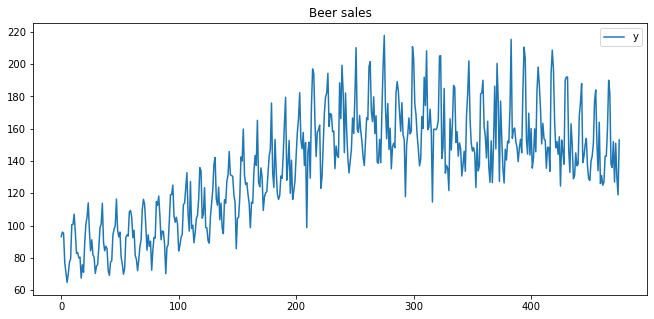

In [23]:
serie = pd.Series(data['Beer'])

# Conversion to pandas dataframe
df = pd.DataFrame()
df['y'] = serie

plt.subplots(figsize=(11, 5))
df['y'].plot()
plt.legend()
plt.title('Beer sales')
plt.show()

## Decompose signal
Decompose signal in Trend, seasonnal ant noise to ease the prediction

In [24]:
def decomposeSignal(signal, seasonnal_period=None, filter_acf=None, padding='same', order=1):
    """Decompose a signal by Trend, seasonnal and noise"""

    if seasonnal_period == None:
        seasonnal_period = getSeasonnalPeriod(signal, order=order, filter_acf=filter_acf, show=False)

    detrend, trend, seasonnal, noise = decomposeWithStatsmodels(signal, period=seasonnal_period)

    if padding == 'same':
        # Imputation of nan borders
        if seasonnal_period == 0:
            seasonnal_period = 10
        trend, detrend = detrendSignalWithFilter(signal, pulse=1 / seasonnal_period)
        noise = signal - trend - seasonnal
    return trend, seasonnal, noise, seasonnal_period

In [25]:
seasonnal_period = None
df['trend'], df['seasonnal'], df['noise'], seasonnal_period = decomposeSignal(df['y'],
                                                                              seasonnal_period=seasonnal_period,
                                                                              padding='same',
                                                                              filter_acf=None,
                                                                              order=1)

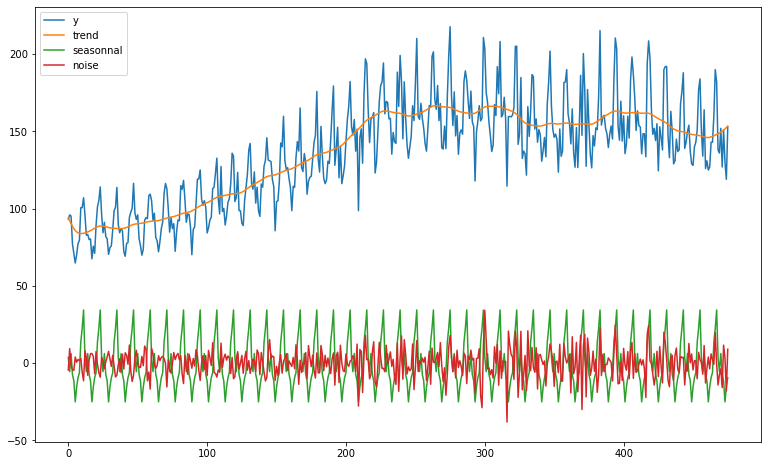

In [26]:
plt.subplots(figsize=(13, 8))
df['y'].plot()
df['trend'].plot()
df['seasonnal'].plot()
df['noise'].plot()
plt.legend()
plt.show()

## Make predictions
Make predictions for each part of signal, n step forward

In [27]:
# Make n predictions
n = 100
df['nan'] = np.nan
forecast_df = pd.DataFrame()

### Predict signal trend
We use sklearn regressor on the signal trend to forecast n steps. 
The model is a pipeline with PolynomialFeatures, StandardScaler and regressor

In [28]:
def forecastWithRegression(signal, n=1, regressor=Ridge(), moving_window=None, polynomial_degree=3, seasonnal_feature=None):
    """Forecast signal trend with sklearn"""
    if moving_window != None:
        y = signal[-moving_window:]
        x = [[i] for i in range(len(list(y)))][-moving_window:]
    else:
        y = signal
        x = [[i] for i in range(len(list(y)))]

    model = make_pipeline(PolynomialFeatures(degree=polynomial_degree), StandardScaler(), regressor)
    model.fit(x, y)

    interpolation = model.predict(x)
    extrapolation = model.predict([[i + len(list(y))] for i in range(n)])

    if moving_window != None:
        interpolation = [np.nan for i in range(len(df['y']) - moving_window)] + list(interpolation)
        
    return interpolation, extrapolation

In [29]:
interpol, extrapol = forecastWithRegression(df['trend'],
                                            n=n,
                                            regressor=Ridge(),
                                            moving_window=None,
                                            polynomial_degree=2)
df['interpolation'] = interpol
forecast_df['predicted_trend'] = list(df['nan']) + list(extrapol)

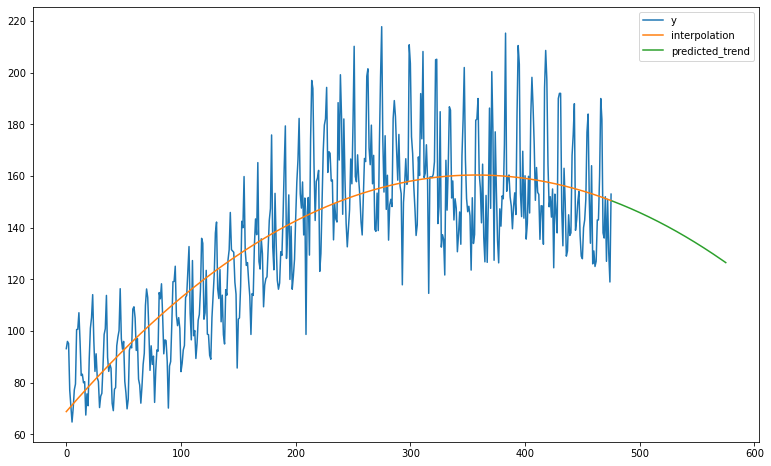

In [30]:
plt.subplots(figsize=(13, 8))
df['y'].plot()
df['interpolation'].plot()
forecast_df['predicted_trend'].plot()
plt.legend()
plt.show()

### Predict signal seasonnality
We use the periodicity of seasonnality to forecast n steps.
If period is None, period will be automatically calculated

In [31]:
def forecastSeasonnality(signal, period=None, n=1, order=1):
    """Forecast seasonnality"""
    forecast_seasonnal = []
    end = len(signal)

    if period == None:
        period = getSeasonnalPeriod(signal, order=order, nlags=None, show=False)

    for i in range(n):
        k = int(i / period) + 1
        forecast_seasonnal.append(signal[end + i - (k * period)])

    return forecast_seasonnal

In [32]:
seasonnal_pred = forecastSeasonnality(df['seasonnal'],
                                      n=n,
                                      period=seasonnal_period)

forecast_df['predicted_seasonnal'] = list(df['nan']) + list(seasonnal_pred)

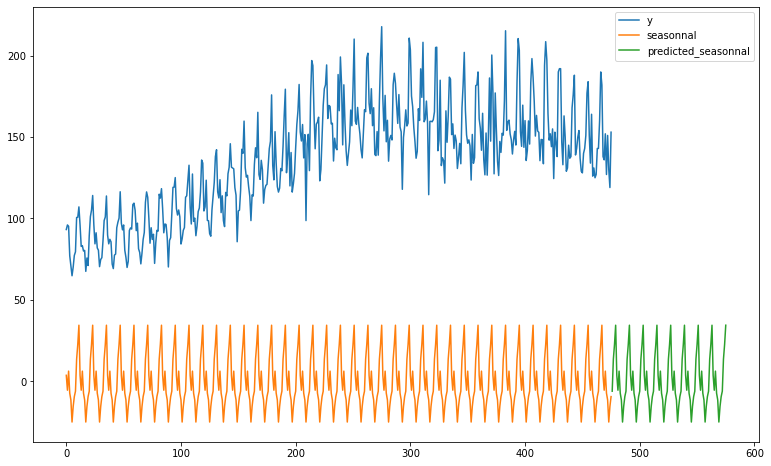

In [33]:
plt.subplots(figsize=(13, 8))
df['y'].plot()
df['seasonnal'].plot()
forecast_df['predicted_seasonnal'].plot()
plt.legend()
plt.show()

### Simulate signal noise
We suppose that noise follow a normal distribution.

In [34]:
def simulateNoise(noise, n=1, shut_noise=False):
    """Generate "logical" random noise"""

    if shut_noise:
        return [0 for i in range(n)]

    mu, std = norm.fit(list(noise))
    forecast_noise = [random.gauss(mu, std) for i in range(n)]

    return forecast_noise

In [35]:
noise_pred = simulateNoise(df['noise'], 
                           n=n,
                           shut_noise=False)

forecast_df['simulated_noise'] = list(df['nan']) + list(noise_pred)

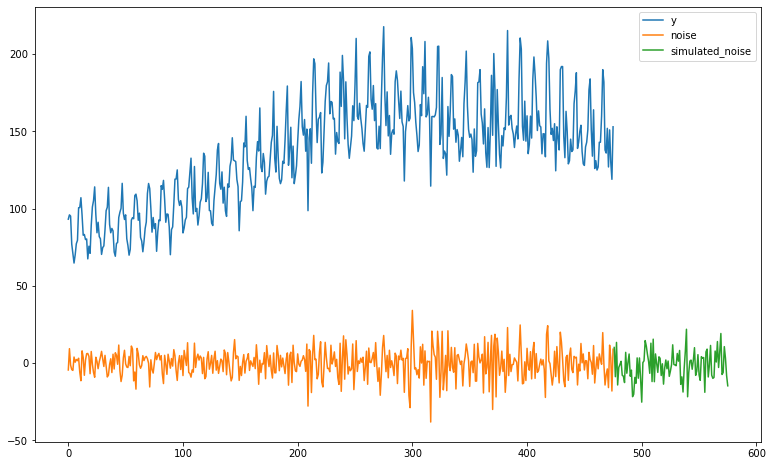

In [36]:
plt.subplots(figsize=(13, 8))
df['y'].plot()
df['noise'].plot()
forecast_df['simulated_noise'].plot()
plt.legend()
plt.show()

### Get final prediction
We sum the three predictions to get the signal forecast.

In [37]:
forecast_df['Predicted'] = forecast_df['predicted_trend'] + forecast_df['predicted_seasonnal'] + forecast_df['simulated_noise']

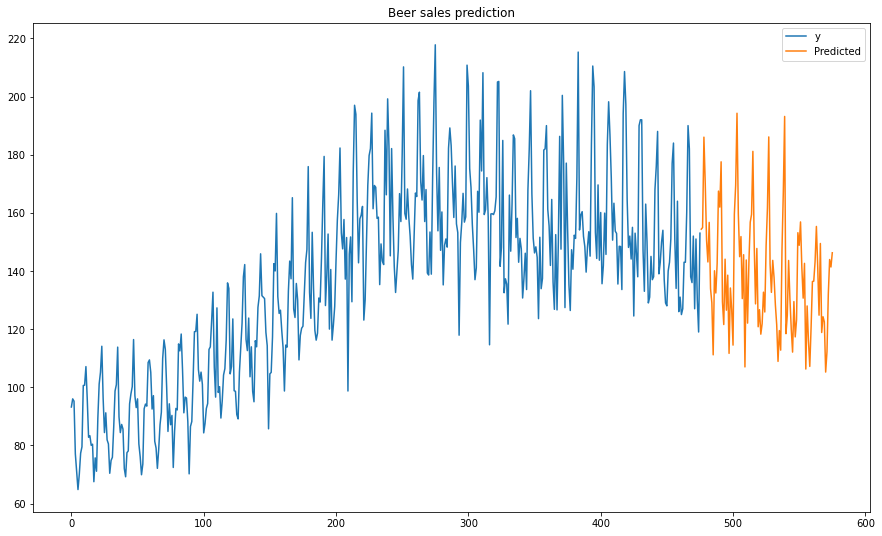

In [38]:
plt.subplots(figsize=(15, 9))
df['y'].plot()
forecast_df['Predicted'].plot()
plt.legend()
plt.title("Beer sales prediction")
plt.show()